<a href="https://colab.research.google.com/github/shivag/cs145-public/blob/main/NanoDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Section 0] Ignore - Visualization Libraries Setup

# [Section 1] Systems Primer
We study a simplified IO model for HDDs and SSDs in cs145. The model will work well in practice, for our query optimzation and data layout problems. For more details on how the devices work, see Optional reads How HDDs work? How SSDs work?


In [1]:
import math
from math import ceil, log

# We'll use MBs -- for basic conversion to MBs
(MB, GB, TB, KB, Bytes) = (1.0, 1024.0, 1024.0*1024.0, 
                           1.0/1024.0, 1.0/(1024.0*1024))

# 64 MB-Blocks (default)
PageSizeMB = 64.0

class IOdevice:
  def __init__(self, accessTime, scanSpeed, C_w, 
               blockSizeMBs = PageSizeMB):
    self.C_r = 1.0
    self.C_w = C_w
    self.accessTime = accessTime
    self.scanSpeed = scanSpeed
    self.blockSizeMBs = blockSizeMBs

  ############
  # Read costs: Simple IOcost model using Access time + Scan speeds 
  def read_pages_cost(self, numPages):
    # Assume you need to read full pages. (i.e., no partial pages)
    numPages = math.ceil(numPages) 
    tsecs = numPages*self.accessTime  # time to access
    tsecs += numPages*self.blockSizeMBs/self.scanSpeed # time to scan
    return (tsecs)

  def write_pages_cost(self, numBlocks):
    return self.C_w*self.readPages(numPages)

# Example IO devices
# Access and Scan speeds in [seconds, MBps], Cw cost of write vs reads.
ram1 = IOdevice(100*pow(10, -9), 100.0*1024, 1.0)
ssd1 = IOdevice(10*pow(10, -6), 5.0*1024, 1.0) # 10 microsecs, 5GBps
hdd1 = IOdevice(10*pow(10, -3), 100.0, 1.0) # 10 millissecs, 100 MBps

IOdevices1 = {'HDD': hdd1, 'SSD': ssd1, 'RAM': ram1}

In [2]:
class Table:
  def __init__(self, sizeInMBs, rowSize):
    self.sizeInMBs = sizeInMBs
    self.rowSize = rowSize
    self.numRows = ceil(self.sizeInMBs/self.rowSize)

    # self.numTuples = numTuples
    self.isSorted = False 
    self.isHPed = False

  # P(R) -- number of Pages for R
  def P(self):
    P = ceil(self.sizeInMBs/PageSizeMB)
    return P
  def RowSize(self):
    return self.rowSize
  def T(self):
    return self.numRows
  def SizeInMBs(self):
    return self.sizeInMBs

  # Keeping track of is table sorted, HPed, or neither (default)
  def Sort(self):
    self.isSorted = True
    self.isHPed = False
  def HP(self):
    self.isSorted = False 
    self.isHPed = True
  def Reset(self):
    self.isSorted = False
    self.isHPed = False

# Example Tables
MB100Table = Table(100.0*MB, 64.0)
GB100Table = Table(100.0*GB, 1024.0)
TB100Table = Table(100.0*TB, 128.0)

# Spotify Songs Table [songid: int64, title: text, name: text, genre: text]
#    -- Size of row = 64 bytes + avg size of title+name+genre. 
#    -- Assume avg row size = 1024 Bytes
songs_rowSize = 1024.0*Bytes 
songs_numRows = 500000000.0 # 500 million songs
songs_sizeinMBs = songs_rowSize*songs_numRows/MB
SongsTable = Table(songs_sizeinMBs, 1024.0)
print(f'{SongsTable.SizeInMBs()=} (MBs), {SongsTable.P()=} pages')
print(f'{ram1.read_pages_cost(100)=} secs')
print(f'{ssd1.read_pages_cost(100)=} secs')
print(f'{hdd1.read_pages_cost(100)=} secs')

SongsTable.SizeInMBs()=488281.25 (MBs), SongsTable.P()=7630 pages
ram1.read_pages_cost(100)=0.06251 secs
ssd1.read_pages_cost(100)=1.251 secs
hdd1.read_pages_cost(100)=65.0 secs


# [Section 2] Simple DB: How to store DbFiles and execute JOINs 

In [3]:
from IPython.display import display, HTML
import pandas as pd
import math

##
# DbFile: How to store and process data. The data is on disk, and managed by a RAM buffer.
class DbFile:
    def __init__(self, values=None, pages=None, k=None, filepfx = ''):
        self.filepfx = filepfx
        self._pad = (None, None)
        if pages:
          self.pages = pages
          self.k = len(pages[0])
          self.P = len(pages)
          self.n = 0
          for i, p in enumerate(pages):
            self.n += len(p)
            while len(p) < self.k:
              self.pages[i].append(self._pad)
        elif not values:
            self.pages = []
            self.P = 1
            self.k = k
            self.n = 0
        else: # got values
          self.k = k
          self.n = len(values) #math.ceil(len(values)/self.k)*self.k
          self.pages = [[self._pad] * k for i in range(math.ceil(len(values)/self.k))]
          self.P = math.ceil(len(values)/k)
          for i, value in enumerate(values):
            page_num, index = divmod(i, k)
            self.pages[page_num][index] = value
      
    # Read num-th page. 
    #    If the page is in RAM, return the same page. If not, read from disk.
    def read_page(self, page_num):
      if self.pages == []:
        return []
      return self.pages[page_num]
    # Write num-th page with page_data. 
    #    If page in RAM, change the values in page. If not, read page from disk, and update values. 
    def write_page(self, page_num, page_data):
        self.pages[page_num] = page_data

    # i-th value ->(page, page-location)
    def read_ith(self, idx):
      pnum, pidx = divmod(idx, self.k)
      return self.read_page(pnum)[pidx]
   
    def is_row_valid(self, row):
      return row != self._pad

    # Append values to the end of the DbFile
    def append_page(self, value):
      # add to last page. Or create new page
      def new_page(value):
        # need new page
        newpage = [(None, None)] * self.k
        newpage[0] = value
        self.pages.append([value] + [(None, None)]*(self.k-1))
        self.P = len(self.pages)
      self.n += 1
      if len(self.pages) > 0:
        last_page = self.pages[self.P -1]
        for i in range(len(last_page)):
          if last_page[i] == (None, None):
            last_page[i] = value
            return
      new_page(value)

    # Splits files into smaller files
    def split_files(self, num_pages_per_split):
      split_files = []
      for i in range(0, self.P, num_pages_per_split):
        end = min(i+num_pages_per_split, self.P)
        tmpp = self.pages[i:end]
        split_files.append(
            DbFile(pages=tmpp, 
                   k=self.k, filepfx = self.filepfx+str(i)))
      return split_files

    ## functions for display
    def print_pages(self):
      for p in range(self.P):
        print("Page", p, ":", self.read_page(p))
    def read_all_pages(self):
      return [self.read_page(p) for p in range(self.P)]
      ## Helper functions for us to see pages
    def format_cell(self, series):
      return ', '.join(str(val) for val in series)
      
    def print_file(self):
      tdf = self.read_all_pages()
      dfList = [[self.filepfx, len(tdf), self.format_cell(tdf)]]
      df = pd.DataFrame(dfList, columns=["DbFiles", 'Num Pages', "Pages"])
      display(HTML(
          df.to_html(index=False, classes=['table', 'table-bordered'],
                     header=['<th style="word-wrap: break-word; max-width: 30px;">Pages</th>'])))  



#Rsort.print_pages()


In [4]:
#################
# Algorithms supported in a DB for JOINs, sorting, hashing, etc
class Algos:
  def __init__(self, B):
    self.B = B
    return 
  

  ## End of display functions

  ##
  # Functions for Sorting
  def split(self, R):
    return R.split_files(self.B)

  # Sort a given (small) file in RAM
  def sortRAM(self, v_list, R):
    concat = []
    for l in v_list: # only use valid rows (ignore padded 'None' rows)
      l = list(filter(lambda x: R.is_row_valid(x), l))
      concat += l
    s_concat = sorted(concat, key=lambda x:x[0])
    sublists = [s_concat[i:i + R.k] for i in range(0, len(s_concat), R.k)]
    return DbFile(pages=sublists, k=R.k, filepfx=R.filepfx)

  # MergeBWay(Rlist): Merge B partially sorted files, into a bigger sorted file
    # Step 1: Read 1st page of each of the B files. Create a small heap in RAM. 
    # Step 2: Repeat below steps until all data is sorted
    # Step 2a:   Select smallest value from the heap, Append to the output file
    # Step 2b:   Read the next value from the file associated with value in 2a
    #            and add it into heap
  def mergeBway(self, Rlist):
    if not Rlist:
      return []
    out = DbFile(values=None, k=Rlist[0].k, filepfx=Rlist[0].filepfx)
    heaps = []
    self.print_files([Rlist])
    # Step 1: Read 1st values. 
    # Also, keep a heap to track values, and which file/page they are from
    for b in range(len(Rlist)):
      page = Rlist[b].read_page(0)
      # value from (sort key, row, bth file, 0th page, 0th slot)
      heapq.heappush(heaps, (page[0][0], page[0], b, 0))

    while (heaps): # Step 2a
      cur_min, row, fnum, vidx = heapq.heappop(heaps)  
      out.append_page(row)
      # Step 2b: Read the next value (after cur_min in same file) 
      vidx += 1
      if vidx < Rlist[fnum].n:
        row = Rlist[fnum].read_ith(vidx)
        heapq.heappush(heaps, (row[0], row, fnum, vidx))
    return [out]

  # ExtSort(R): Sort a big file (does not fit in RAM)
    # 1. Split big file into many small files (i.e., each fits into B RAM)
    # 2. Sort each small file (in RAM)
    # 3. Merge B sorted files at a time
  def ExtSort(self, R, display=True):
    # Step 1 and 2
    split_files = self.split(R)
    merged_files = [[self.sortRAM(fsplit.read_all_pages(), R) \
                     for fsplit in split_files]]
    numpass = 0

    # Step 3
    while (len(merged_files[numpass]) > 1):
      mfiles = []
      for start in range(0, len(merged_files[numpass]), self.B):
        end = min(start + self.B, len(merged_files[numpass]))
        mfiles += self.mergeBway(merged_files[numpass][start:end])
      merged_files.append(mfiles)
      numpass += 1
    if display:
      self.print_files(merged_files, add_sfx=True)
    return merged_files[numpass]

  # SMJ(R): SortMerge Join R and S
    # Step 1: Sort R and S (stored as DbFiles)
    # Step 2: Iterate thro' each page of R and S, in sequence 
  def SMJ(self, inR, inS, outk):
    # Step1
    R = self.ExtSort(inR)[0]; S = self.ExtSort(inS)[0]

    out_file = DbFile(values=[], k = outk, filepfx=R.filepfx + "-" + S.filepfx)
    ridx = 0; sidx = 0
    # Step 2: Merge 2 sorted files.  
    #       
    while (ridx < R.n and sidx < S.n):
      r = R.read_ith(ridx); s = S.read_ith(sidx)
      if r[0] < s[0]:
        ridx += 1
      if r[0] > s[0]:
        sidx += 1
      if r[0] == s[0]:
        # Scan through all equal values. Backup when necessary
        # E.g., R=[... 'bb', 'bb', 'cc', ...] and S=[...'bb', 'cc', 'cc', ...]
        # Make sure to match all 'bb' and 'cc's. 
        backup_sidx = sidx
        while r[0] == s[0] and sidx < S.n:
          out_file.append_page((r[0],)+r[1:]+s[1:])
          sidx += 1
          s = S.read_ith(sidx)
        ridx += 1
        sidx = backup_sidx

    self.print_files([[out_file]])
    return out_file

  ## Functions for Hashing
  #
  # HP(R): Hash partition a big file
    # Step 1: Set up B partitions (stored as DbFiles)
    # Step 2: Read each page of R into RAM. 
    # Step 3: Hash each value h(v). Append to the h(v)th partition.
    # IOCosts:
    #     Read R's pages -- IOCost = P(R)
    #     Append hashed output -- IOCost = P(R)
  def HashP(self, R):
    # internal fn to hash a given integer or string
    import hashlib
    def hash_value(value):
      if isinstance(value, int):
        return hash(value) % self.B
      sha256 = hashlib.sha256()
      sha256.update(value.encode('utf-8'))
      return int(sha256.hexdigest(), 16) % self.B
  
    ## Step 1
    hash_files = [DbFile(values=[], k=R.k, filepfx=R.filepfx + f'.{i}') \
                  for i in range(self.B)]
    # Steps 2 and 3
    for i in range(R.P):
      page = R.read_page(i) ## Step 1
      for j in range(len(page)): ## process values in RAM
        if R.is_row_valid(page[j]):
          h = hash_value(page[j][0])
          hash_files[h].append_page(page[j]) # Step 2
    self.print_files([hash_files])
    return hash_files


  # HPJ(R, S): Join R and S with Hash Partition Joins
    # Step 1: HP(R), HP(S)
    # Step 2: For each partition, run BNLJ(). Finally append 
  def HPJ(self, R, S, outk):
    # Step 1
    rhash = self.HashP(R)
    shash = self.HashP(S)
    hpjout = []
    # Step 2
    for i in range(self.B):
      hpjout.append(self.BNLJ(rhash[i], shash[i], outk))
    
  
  # BNLJ(R, S): Joins R and S using a block-nested loop algo
    # Step 1. Read R's pages into RAM, 'B' pages at a time. 
    #    (And cache these 'B' pages in RAM)
    # Step 2. Read S's pages to join with R's cached pages.
    # I.e., IOCost = P(R) + P(R)*P(S)/B + OUT
  def BNLJ(self, R, S, outk):
    out = DbFile(values=[], k=outk, 
                 filepfx=R.filepfx + '-join-' + S.filepfx)
    for i in range(0, R.P, self.B): # Step 1
      pages_R = [R.read_page(j) \
                 for j in range(i, min(i + self.B, R.P))] # IO-cost
      for j in range(S.P): # Step 2
        page_S = S.read_page(j) # IO-cost
        for p in pages_R: # Below is in RAM. I.e. IO-cost = 0
          for r in p:
            if not R.is_row_valid(r):
              continue
            for s in page_S:
              if not S.is_row_valid(s) or r[0] != s[0]:
                continue
              out.append_page((r[0],) + r[1:] + s[1:]) # IO-cost to append
    self.print_files([[out]])
    return out

  def format_cell(self, series):
    return ', '.join(str(val) for val in series)
  def print_files(self, mfiles, add_sfx=False):
    for i, mfile in enumerate(mfiles):
      dfList = []
      pd.options.display.max_colwidth = 10
      for j, dfile in enumerate(mfile):
        tdf = dfile.read_all_pages()
        filesfx = '-' + str(i) + "-" + str(j) if (add_sfx) else ""
        dfList.append([dfile.filepfx + filesfx, len(tdf), self.format_cell(tdf)])
      df = pd.DataFrame(dfList, columns=["DbFiles", 'Num Pages', "Pages"])
      display(HTML(
          df.to_html(index=False, classes=['table', 'table-bordered'],
                     header=['<th style="word-wrap: break-word; max-width: 30px;">Pages</th>'])))

class IndexFile(DbFile):
  def __init__(self, data, outk):
    self.idxType = 'basic'
    self.numIOs = 0
    self.outindex = ''
    self.algo = Algos(4)
    self.R = data
    self.outk = outk

  # Build a basic index, given a DbFile. 
  # Each index entry contains (value, page#). The entry indicates 
  # the value and the page# of the value in the given DbFile.
  #   Step 1: Read each page in DbFile.
  #   Step 2: Add (value, page#) to index, for each value in page. 
  #   Step 3: Sort the final index, for easy searching
  # Possible extensions -- 
  # 1. Compress the index by storing blooom filters instead of value. 
  # 2. For simplicity of code, we're indexing the 0th column. We can create 
  #    indexes on combinations (e.g. on two or more columns)
  def MakeBasicIndex(self, sort=True, level=1):
    tmpindex = DbFile(values=[], k=self.outk, 
                                  filepfx=self.R.filepfx +f'.idx')
    for i in range(self.R.P): # Step 1
      page = self.R.read_page(i)
      for j in range(len(page)):
        if self.R.is_row_valid(page[j]): # Step 2
        # For simplicity, index only the 0th column
        # In general, index (value -> value's page#)
          tmpindex.append_page((page[j][0], i))
    if sort: # Step 3
      self.idxType = 'basicSorted'
      self.outindex = self.algo.ExtSort(tmpindex, False)[0]
    else:
      self.outindex = tmpindex
    return self.outindex

  # Create an index over a Sorted DbFile
  # Index only the 1st value in each sorted page.
  # E.g., val_i in page_i and val_j in page_j. 
  # When searching for a value,
  # only values between val_i and val_j will be in page_i. 
  def MakeIndexForSortedData(self, level=1):
    self.idxType = 'onSortedData'
    tmpindex = DbFile(values=[], k=self.outk, 
                      filepfx=self.R.filepfx + f'.idx')
    for i in range(self.R.P):
      page = self.R.read_page(i)
      if self.R.is_row_valid(page[0]):
        tmpindex.append_page((page[0][0], i))
    self.outindex = self.algo.ExtSort(tmpindex, False)[0]
    return self.outindex
  
  # Make a multi-level index. 
  # Create R.idx for table R. Create R.idx.idx for R.idx, and so on. 
  # Index the data as usual. OrganizeIndex the index , for faster navigation.
  def MakeBPlusTreeIndex(self, fanout, clustered=False):
    self.idxType = 'b+tree'
    level=1
    b = IndexFile(self.R, fanout)
    if clustered:
      self.bindex = [b.MakeIndexForSortedData(level=level)]
    else:
      self.bindex = [b.MakeBasicIndex(level=level)]
    while (self.bindex[-1].P > 1):
      n = IndexFile(self.bindex[-1], fanout)
      level += 1
      next = n.MakeIndexForSortedData(level=level)
      next.print_file()
      self.bindex += [next]
    self.bindex.reverse()

  def print_file(self):
    if self.idxType == 'b+tree':
      for idx in self.bindex:
        idx.print_file()
    else:
      self.outindex.print_file()
  
  def GetData(self, kval, datapagenum):
    datapage = self.R.read_page(datapagenum)
    for i in range(len(datapage)):
      if self.R.is_row_valid(datapage[i]):
        row = datapage[i]
        if row[0] == kval: # indexing on 1st column
          print(f'Found {row=}')
          return row
    return None

  ## Find kval in index
  #   For querying for a needed value, we'll see code to 
  #     -Scan the index to find the page# with the value. Read that data page
  #     -If the value is not found in the index, the value is not in the data. 
  # Note: The code below works when the data does not have duplicates. 
  # Modiyfing it to handle duplicates is easy once you understand this version.
  def QueryIndex(self, kval):
    idx = self.outindex
    self.numIOs = 0
    # Step 1: Walk through Index pages in sequence
    # Step 2: If Index is sorted, stop when we find a bigger value
    for page in idx.read_all_pages():
      self.numIOs += 1
      for idxval, pagenum in page: ## process values in RAM
        if idxval != None and kval == idxval:
          return self.numIOs, self.GetData(kval, pagenum)
        if idxval > kval and self.idxType in ['basicSorted', 'onSortedData']:
          # if sorted, can stop searching. Value not found
          return self.numIOs, None
    return self.numIOs, None

  ## Find kval in B+ tree index
  # Note: The code below works when the index does not have duplicates.
  def QueryBplusIndex(self, kval):
    idxpagenum = 0
    self.numIOs = 0
    # Step 1: Walk through the tree from root to leaf nodes.
    # Step 2: Read the data page, using pagenum from the leaf node 
    for idx in self.bindex: # Step 1
      page = idx.read_page(idxpagenum)
      self.numIOs += 1
      for idxval, pagenum in page:
        if idxval != None and idxval <= kval: 
          idxpagenum = pagenum # Track the next level
    # Step 2
    return self.numIOs, self.GetData(kval, idxpagenum)
      
    



In [7]:
import random, heapq, string

def gen_random_string(string_length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

# create sample tables with n-rows of [<int, string of 'l' chars>]
def gen_random_rows(l, n, seed):
  random.seed(seed)
  return [(random.randint(1, 500), gen_random_string(l), '..') for i in range(n)]

random.seed(3141)
R = DbFile(values=[gen_random_string(2) for i in range(100)], k=3, filepfx='R')

Songs = DbFile(values=gen_random_rows(2, 100, 3141), k=3, filepfx='Songs')
Listens = DbFile(values=gen_random_rows(2, 100, 4242), k=7, filepfx='Listens')
#Songs.print_file()
#Listens.print_file()

#print("======= Input files")
algo = Algos(4)
Songs.print_file()
Listens.print_file()
SongsSorted = algo.ExtSort(Songs)
#ListensSorted = algo.ExtSort(Listens)
#s1parts = algo.HashP(Songs)
#algo.print_files(r1index)
#algo.print_file(S1)
algo.BNLJ(Songs, Listens, 4)
algo.HPJ(Songs, Listens, 4)
algo.SMJ(Songs, Listens, 4)
pd.set_option('display.max_colwidth', None)
#algo.print_file(R)
#algo.ExtSort(R)
#algo.ExtSort(S)

#algo.print_file(S)
#join = algo.HPJ(R1, S1, 4)

DbFiles,Num Pages,Pages
Songs,34,"[(188, 'kg', '..'), (492, 'oa', '..'), (359, 'cl', '..')], [(163, 'kn', '..'), (458, 'dx', '..'), (210, 'wl', '..')], [(123, 'cm', '..'), (494, 'bd', '..'), (486, 'vb', '..')], [(474, 'nt', '..'), (358, 'vu', '..'), (35, 'ez', '..')], [(21, 'lk', '..'), (288, 'nk', '..'), (229, 'sq', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (203, 'kz', '..'), (169, 'ak', '..')], [(234, 'yc', '..'), (357, 'in', '..'), (396, 'at', '..')], [(167, 'uw', '..'), (232, 'pm', '..'), (230, 'oa', '..')], [(131, 'fz', '..'), (477, 'gi', '..'), (327, 'zs', '..')], [(29, 'uh', '..'), (305, 'hp', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (489, 'uc', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (80, 'br', '..'), (318, 'oa', '..')], [(320, 'ut', '..'), (101, 'ya', '..'), (197, 'rm', '..')], [(402, 'mn', '..'), (255, 'uf', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (484, 'xd', '..'), (301, 'cp', '..')], [(243, 'hx', '..'), (18, 'lx', '..'), (328, 'jf', '..')], [(446, 'ew', '..'), (178, 'qf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (179, 'dg', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (379, 'oj', '..'), (232, 'pk', '..')], [(194, 'ro', '..'), (110, 'um', '..'), (494, 'jf', '..')], [(375, 'ur', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(364, 'mq', '..'), (80, 'zy', '..'), (359, 'mj', '..')], [(292, 'xe', '..'), (207, 'hh', '..'), (134, 'mp', '..')], [(440, 'fi', '..'), (419, 'qp', '..'), (428, 've', '..')], [(383, 'rx', '..'), (166, 'aa', '..'), (266, 'bd', '..')], [(242, 'oc', '..'), (137, 'rd', '..'), (25, 'me', '..')], [(194, 'iq', '..'), (66, 'at', '..'), (261, 'dr', '..')], [(310, 'un', '..'), (491, 'uu', '..'), (416, 'nl', '..')], [(299, 'ha', '..'), (353, 'fr', '..'), (85, 'gk', '..')], [(141, 'yb', '..'), (96, 'yo', '..'), (23, 'ba', '..')], [(167, 'zp', '..'), (70, 'vt', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (429, 'al', '..'), (170, 'hy', '..')], [(17, 'oa', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens,15,"[(442, 'ne', '..'), (15, 'tm', '..'), (195, 'ki', '..'), (95, 'qp', '..'), (13, 'pf', '..'), (80, 'sy', '..'), (345, 'pd', '..')], [(14, 'eq', '..'), (73, 'fk', '..'), (63, 'fw', '..'), (122, 'ws', '..'), (343, 'uh', '..'), (466, 'ob', '..'), (468, 'ik', '..')], [(3, 'kf', '..'), (265, 'kv', '..'), (183, 'tm', '..'), (207, 'kx', '..'), (158, 'zf', '..'), (177, 'tr', '..'), (249, 'io', '..')], [(41, 'zx', '..'), (433, 'pi', '..'), (86, 'tf', '..'), (467, 'jp', '..'), (143, 'cd', '..'), (373, 'mn', '..'), (341, 'op', '..')], [(118, 'ph', '..'), (54, 'to', '..'), (213, 'rn', '..'), (114, 'hl', '..'), (366, 'gq', '..'), (196, 'cj', '..'), (457, 'zb', '..')], [(274, 'gd', '..'), (217, 'ax', '..'), (13, 'xr', '..'), (220, 'tv', '..'), (296, 'gz', '..'), (486, 'iw', '..'), (419, 'np', '..')], [(497, 'gn', '..'), (181, 'hf', '..'), (411, 'nz', '..'), (257, 'aq', '..'), (479, 'mu', '..'), (58, 'pz', '..'), (490, 'th', '..')], [(239, 'lv', '..'), (152, 'dr', '..'), (280, 'we', '..'), (442, 'aa', '..'), (463, 'fb', '..'), (264, 'oe', '..'), (107, 'hk', '..')], [(190, 'ze', '..'), (162, 'dg', '..'), (236, 'ot', '..'), (9, 'ji', '..'), (127, 'wl', '..'), (50, 'vf', '..'), (346, 'vs', '..')], [(69, 'ev', '..'), (37, 'ec', '..'), (294, 'ld', '..'), (14, 'xo', '..'), (442, 'fi', '..'), (210, 'gw', '..'), (285, 'fg', '..')], [(427, 'rs', '..'), (227, 'me', '..'), (438, 'pd', '..'), (448, 'dh', '..'), (463, 'iq', '..'), (205, 'wz', '..'), (31, 'yj', '..')], [(460, 'mt', '..'), (483, 'nf', '..'), (443, 'yy', '..'), (392, 'iy', '..'), (67, 'az', '..'), (468, 'up', '..'), (22, 'ko', '..')], [(286, 'mf', '..'), (448, 'ee', '..'), (166, 'nv', '..'), (113, 'vh', '..'), (183, 'pd', '..'), (148, 'qv', '..'), (429, 'zh', '..')], [(396, 'gx', '..'), (142, 'vj', '..'), (29, 'xf', '..'), (229, 'co', '..'), (219, 'xe', '..'), (367, 'kc', '..'), (478, 'ce', '..')], [(335, 'dh', '..'), (116, 'et', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"


DbFiles,Num Pages,Pages
Songs,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-0-0,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-0-1,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs-0-2,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs-0-3,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"
Songs-0-4,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs-0-5,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs-0-6,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs-0-7,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"
Songs-0-8,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-1-0,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-1-1,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs-1-2,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-2-0,34,"[(14, 'nc', '..'), (17, 'oa', '..'), (18, 'lx', '..')], [(21, 'lk', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(29, 'uh', '..'), (35, 'ez', '..'), (41, 'na', '..')], [(63, 'iv', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'br', '..'), (80, 'zy', '..')], [(85, 'gk', '..'), (96, 'yo', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (110, 'um', '..'), (123, 'cm', '..')], [(124, 'xi', '..'), (126, 'my', '..'), (131, 'fz', '..')], [(134, 'mp', '..'), (137, 'rd', '..'), (141, 'yb', '..')], [(163, 'kn', '..'), (166, 'aa', '..'), (167, 'uw', '..')], [(167, 'zp', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(170, 'hy', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (188, 'kg', '..'), (192, 'pc', '..')], [(194, 'iq', '..'), (194, 'ro', '..'), (197, 'rm', '..')], [(203, 'kz', '..'), (207, 'hh', '..'), (210, 'wl', '..')], [(214, 'nx', '..'), (229, 'sq', '..'), (230, 'oa', '..')], [(232, 'pk', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (246, 'ir', '..')], [(255, 'uf', '..'), (261, 'dr', '..'), (266, 'bd', '..')], [(279, 'fz', '..'), (288, 'nk', '..'), (292, 'xe', '..')], [(299, 'ha', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(310, 'un', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(327, 'zs', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(359, 'mj', '..'), (363, 'ma', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (379, 'oj', '..'), (383, 'rx', '..')], [(396, 'at', '..'), (402, 'mn', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (429, 'al', '..')], [(432, 'it', '..'), (440, 'fi', '..'), (446, 'ew', '..')], [(450, 'gm', '..'), (453, 'lq', '..'), (458, 'dx', '..')], [(474, 'nt', '..'), (477, 'gi', '..'), (484, 'xd', '..')], [(486, 'vb', '..'), (489, 'uc', '..'), (491, 'uu', '..')], [(492, 'oa', '..'), (494, 'bd', '..'), (494, 'jf', '..')], [(499, 'dh', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-join-Listens,4,"[(486, 'vb', '..', 'iw', '..'), (210, 'wl', '..', 'gw', '..'), (229, 'sq', '..', 'co', '..'), (396, 'at', '..', 'gx', '..')], [(29, 'uh', '..', 'xf', '..'), (80, 'br', '..', 'sy', '..'), (14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..')], [(41, 'na', '..', 'zx', '..'), (80, 'zy', '..', 'sy', '..'), (177, 'fg', '..', 'tr', '..'), (207, 'hh', '..', 'kx', '..')], [(419, 'qp', '..', 'np', '..'), (166, 'aa', '..', 'nv', '..'), (63, 'iv', '..', 'fw', '..'), (429, 'al', '..', 'zh', '..')]"


DbFiles,Num Pages,Pages
Songs.0,7,"[(188, 'kg', '..'), (492, 'oa', '..'), (288, 'nk', '..')], [(396, 'at', '..'), (232, 'pm', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (80, 'br', '..'), (320, 'ut', '..')], [(484, 'xd', '..'), (328, 'jf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (232, 'pk', '..'), (364, 'mq', '..')], [(80, 'zy', '..'), (292, 'xe', '..'), (440, 'fi', '..')], [(428, 've', '..'), (416, 'nl', '..'), (96, 'yo', '..')]"
Songs.1,8,"[(21, 'lk', '..'), (229, 'sq', '..'), (169, 'ak', '..')], [(357, 'in', '..'), (477, 'gi', '..'), (29, 'uh', '..')], [(305, 'hp', '..'), (489, 'uc', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (301, 'cp', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(137, 'rd', '..'), (25, 'me', '..'), (261, 'dr', '..')], [(353, 'fr', '..'), (85, 'gk', '..'), (141, 'yb', '..')], [(429, 'al', '..'), (17, 'oa', '..'), (None, None)]"
Songs.2,11,"[(458, 'dx', '..'), (210, 'wl', '..'), (494, 'bd', '..')], [(486, 'vb', '..'), (474, 'nt', '..'), (358, 'vu', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (234, 'yc', '..'), (230, 'oa', '..')], [(318, 'oa', '..'), (402, 'mn', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (18, 'lx', '..'), (446, 'ew', '..')], [(178, 'qf', '..'), (194, 'ro', '..'), (110, 'um', '..')], [(494, 'jf', '..'), (134, 'mp', '..'), (166, 'aa', '..')], [(266, 'bd', '..'), (242, 'oc', '..'), (194, 'iq', '..')], [(66, 'at', '..'), (310, 'un', '..'), (70, 'vt', '..')], [(170, 'hy', '..'), (None, None), (None, None)]"
Songs.3,9,"[(359, 'cl', '..'), (163, 'kn', '..'), (123, 'cm', '..')], [(35, 'ez', '..'), (203, 'kz', '..'), (167, 'uw', '..')], [(131, 'fz', '..'), (327, 'zs', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (255, 'uf', '..'), (243, 'hx', '..')], [(179, 'dg', '..'), (379, 'oj', '..'), (375, 'ur', '..')], [(359, 'mj', '..'), (207, 'hh', '..'), (419, 'qp', '..')], [(383, 'rx', '..'), (491, 'uu', '..'), (299, 'ha', '..')], [(23, 'ba', '..'), (167, 'zp', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens.0,3,"[(80, 'sy', '..'), (468, 'ik', '..'), (196, 'cj', '..'), (220, 'tv', '..'), (296, 'gz', '..'), (152, 'dr', '..'), (280, 'we', '..')], [(264, 'oe', '..'), (236, 'ot', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (392, 'iy', '..'), (468, 'up', '..'), (448, 'ee', '..')], [(148, 'qv', '..'), (396, 'gx', '..'), (116, 'et', '..'), (None, None), (None, None), (None, None), (None, None)]"
Listens.1,4,"[(13, 'pf', '..'), (345, 'pd', '..'), (73, 'fk', '..'), (265, 'kv', '..'), (177, 'tr', '..'), (249, 'io', '..'), (41, 'zx', '..')], [(433, 'pi', '..'), (373, 'mn', '..'), (341, 'op', '..'), (213, 'rn', '..'), (457, 'zb', '..'), (217, 'ax', '..'), (13, 'xr', '..')], [(497, 'gn', '..'), (181, 'hf', '..'), (257, 'aq', '..'), (9, 'ji', '..'), (69, 'ev', '..'), (37, 'ec', '..'), (285, 'fg', '..')], [(205, 'wz', '..'), (113, 'vh', '..'), (429, 'zh', '..'), (29, 'xf', '..'), (229, 'co', '..'), (None, None), (None, None)]"
Listens.2,5,"[(442, 'ne', '..'), (14, 'eq', '..'), (122, 'ws', '..'), (466, 'ob', '..'), (158, 'zf', '..'), (86, 'tf', '..'), (118, 'ph', '..')], [(54, 'to', '..'), (114, 'hl', '..'), (366, 'gq', '..'), (274, 'gd', '..'), (486, 'iw', '..'), (58, 'pz', '..'), (490, 'th', '..')], [(442, 'aa', '..'), (190, 'ze', '..'), (162, 'dg', '..'), (50, 'vf', '..'), (346, 'vs', '..'), (294, 'ld', '..'), (14, 'xo', '..')], [(442, 'fi', '..'), (210, 'gw', '..'), (438, 'pd', '..'), (22, 'ko', '..'), (286, 'mf', '..'), (166, 'nv', '..'), (142, 'vj', '..')], [(478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"
Listens.3,4,"[(15, 'tm', '..'), (195, 'ki', '..'), (95, 'qp', '..'), (63, 'fw', '..'), (343, 'uh', '..'), (3, 'kf', '..'), (183, 'tm', '..')], [(207, 'kx', '..'), (467, 'jp', '..'), (143, 'cd', '..'), (419, 'np', '..'), (411, 'nz', '..'), (479, 'mu', '..'), (239, 'lv', '..')], [(463, 'fb', '..'), (107, 'hk', '..'), (127, 'wl', '..'), (427, 'rs', '..'), (227, 'me', '..'), (463, 'iq', '..'), (31, 'yj', '..')], [(483, 'nf', '..'), (443, 'yy', '..'), (67, 'az', '..'), (183, 'pd', '..'), (219, 'xe', '..'), (367, 'kc', '..'), (335, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs.0-join-Listens.0,1,"[(80, 'br', '..', 'sy', '..'), (396, 'at', '..', 'gx', '..'), (80, 'zy', '..', 'sy', '..'), (None, None)]"


DbFiles,Num Pages,Pages
Songs.1-join-Listens.1,2,"[(229, 'sq', '..', 'co', '..'), (29, 'uh', '..', 'xf', '..'), (41, 'na', '..', 'zx', '..'), (177, 'fg', '..', 'tr', '..')], [(429, 'al', '..', 'zh', '..'), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.2-join-Listens.2,2,"[(486, 'vb', '..', 'iw', '..'), (210, 'wl', '..', 'gw', '..'), (14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..')], [(166, 'aa', '..', 'nv', '..'), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.3-join-Listens.3,1,"[(207, 'hh', '..', 'kx', '..'), (419, 'qp', '..', 'np', '..'), (63, 'iv', '..', 'fw', '..'), (None, None)]"


DbFiles,Num Pages,Pages
Songs,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"


DbFiles,Num Pages,Pages
Songs,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-0-0,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-0-1,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs-0-2,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs-0-3,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"
Songs-0-4,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs-0-5,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs-0-6,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs-0-7,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"
Songs-0-8,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-1-0,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-1-1,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs-1-2,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-2-0,34,"[(14, 'nc', '..'), (17, 'oa', '..'), (18, 'lx', '..')], [(21, 'lk', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(29, 'uh', '..'), (35, 'ez', '..'), (41, 'na', '..')], [(63, 'iv', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'br', '..'), (80, 'zy', '..')], [(85, 'gk', '..'), (96, 'yo', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (110, 'um', '..'), (123, 'cm', '..')], [(124, 'xi', '..'), (126, 'my', '..'), (131, 'fz', '..')], [(134, 'mp', '..'), (137, 'rd', '..'), (141, 'yb', '..')], [(163, 'kn', '..'), (166, 'aa', '..'), (167, 'uw', '..')], [(167, 'zp', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(170, 'hy', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (188, 'kg', '..'), (192, 'pc', '..')], [(194, 'iq', '..'), (194, 'ro', '..'), (197, 'rm', '..')], [(203, 'kz', '..'), (207, 'hh', '..'), (210, 'wl', '..')], [(214, 'nx', '..'), (229, 'sq', '..'), (230, 'oa', '..')], [(232, 'pk', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (246, 'ir', '..')], [(255, 'uf', '..'), (261, 'dr', '..'), (266, 'bd', '..')], [(279, 'fz', '..'), (288, 'nk', '..'), (292, 'xe', '..')], [(299, 'ha', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(310, 'un', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(327, 'zs', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(359, 'mj', '..'), (363, 'ma', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (379, 'oj', '..'), (383, 'rx', '..')], [(396, 'at', '..'), (402, 'mn', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (429, 'al', '..')], [(432, 'it', '..'), (440, 'fi', '..'), (446, 'ew', '..')], [(450, 'gm', '..'), (453, 'lq', '..'), (458, 'dx', '..')], [(474, 'nt', '..'), (477, 'gi', '..'), (484, 'xd', '..')], [(486, 'vb', '..'), (489, 'uc', '..'), (491, 'uu', '..')], [(492, 'oa', '..'), (494, 'bd', '..'), (494, 'jf', '..')], [(499, 'dh', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens,4,"[(3, 'kf', '..'), (13, 'pf', '..'), (14, 'eq', '..'), (15, 'tm', '..'), (41, 'zx', '..'), (63, 'fw', '..'), (73, 'fk', '..')], [(80, 'sy', '..'), (86, 'tf', '..'), (95, 'qp', '..'), (122, 'ws', '..'), (143, 'cd', '..'), (158, 'zf', '..'), (177, 'tr', '..')], [(183, 'tm', '..'), (195, 'ki', '..'), (207, 'kx', '..'), (249, 'io', '..'), (265, 'kv', '..'), (341, 'op', '..'), (343, 'uh', '..')], [(345, 'pd', '..'), (373, 'mn', '..'), (433, 'pi', '..'), (442, 'ne', '..'), (466, 'ob', '..'), (467, 'jp', '..'), (468, 'ik', '..')]"
Listens,4,"[(13, 'xr', '..'), (54, 'to', '..'), (58, 'pz', '..'), (107, 'hk', '..'), (114, 'hl', '..'), (118, 'ph', '..'), (152, 'dr', '..')], [(181, 'hf', '..'), (196, 'cj', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (220, 'tv', '..'), (239, 'lv', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (274, 'gd', '..'), (280, 'we', '..'), (296, 'gz', '..'), (366, 'gq', '..'), (411, 'nz', '..'), (419, 'np', '..')], [(442, 'aa', '..'), (457, 'zb', '..'), (463, 'fb', '..'), (479, 'mu', '..'), (486, 'iw', '..'), (490, 'th', '..'), (497, 'gn', '..')]"
Listens,4,"[(9, 'ji', '..'), (14, 'xo', '..'), (22, 'ko', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (50, 'vf', '..'), (67, 'az', '..')], [(69, 'ev', '..'), (127, 'wl', '..'), (162, 'dg', '..'), (190, 'ze', '..'), (205, 'wz', '..'), (210, 'gw', '..'), (227, 'me', '..')], [(236, 'ot', '..'), (285, 'fg', '..'), (294, 'ld', '..'), (346, 'vs', '..'), (392, 'iy', '..'), (427, 'rs', '..'), (438, 'pd', '..')], [(442, 'fi', '..'), (443, 'yy', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (463, 'iq', '..'), (468, 'up', '..'), (483, 'nf', '..')]"
Listens,3,"[(29, 'xf', '..'), (113, 'vh', '..'), (116, 'et', '..'), (142, 'vj', '..'), (148, 'qv', '..'), (166, 'nv', '..'), (183, 'pd', '..')], [(219, 'xe', '..'), (229, 'co', '..'), (286, 'mf', '..'), (335, 'dh', '..'), (367, 'kc', '..'), (396, 'gx', '..'), (429, 'zh', '..')], [(448, 'ee', '..'), (478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-0-0,4,"[(3, 'kf', '..'), (13, 'pf', '..'), (14, 'eq', '..'), (15, 'tm', '..'), (41, 'zx', '..'), (63, 'fw', '..'), (73, 'fk', '..')], [(80, 'sy', '..'), (86, 'tf', '..'), (95, 'qp', '..'), (122, 'ws', '..'), (143, 'cd', '..'), (158, 'zf', '..'), (177, 'tr', '..')], [(183, 'tm', '..'), (195, 'ki', '..'), (207, 'kx', '..'), (249, 'io', '..'), (265, 'kv', '..'), (341, 'op', '..'), (343, 'uh', '..')], [(345, 'pd', '..'), (373, 'mn', '..'), (433, 'pi', '..'), (442, 'ne', '..'), (466, 'ob', '..'), (467, 'jp', '..'), (468, 'ik', '..')]"
Listens-0-1,4,"[(13, 'xr', '..'), (54, 'to', '..'), (58, 'pz', '..'), (107, 'hk', '..'), (114, 'hl', '..'), (118, 'ph', '..'), (152, 'dr', '..')], [(181, 'hf', '..'), (196, 'cj', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (220, 'tv', '..'), (239, 'lv', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (274, 'gd', '..'), (280, 'we', '..'), (296, 'gz', '..'), (366, 'gq', '..'), (411, 'nz', '..'), (419, 'np', '..')], [(442, 'aa', '..'), (457, 'zb', '..'), (463, 'fb', '..'), (479, 'mu', '..'), (486, 'iw', '..'), (490, 'th', '..'), (497, 'gn', '..')]"
Listens-0-2,4,"[(9, 'ji', '..'), (14, 'xo', '..'), (22, 'ko', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (50, 'vf', '..'), (67, 'az', '..')], [(69, 'ev', '..'), (127, 'wl', '..'), (162, 'dg', '..'), (190, 'ze', '..'), (205, 'wz', '..'), (210, 'gw', '..'), (227, 'me', '..')], [(236, 'ot', '..'), (285, 'fg', '..'), (294, 'ld', '..'), (346, 'vs', '..'), (392, 'iy', '..'), (427, 'rs', '..'), (438, 'pd', '..')], [(442, 'fi', '..'), (443, 'yy', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (463, 'iq', '..'), (468, 'up', '..'), (483, 'nf', '..')]"
Listens-0-3,3,"[(29, 'xf', '..'), (113, 'vh', '..'), (116, 'et', '..'), (142, 'vj', '..'), (148, 'qv', '..'), (166, 'nv', '..'), (183, 'pd', '..')], [(219, 'xe', '..'), (229, 'co', '..'), (286, 'mf', '..'), (335, 'dh', '..'), (367, 'kc', '..'), (396, 'gx', '..'), (429, 'zh', '..')], [(448, 'ee', '..'), (478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-1-0,15,"[(3, 'kf', '..'), (9, 'ji', '..'), (13, 'pf', '..'), (13, 'xr', '..'), (14, 'eq', '..'), (14, 'xo', '..'), (15, 'tm', '..')], [(22, 'ko', '..'), (29, 'xf', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (41, 'zx', '..'), (50, 'vf', '..'), (54, 'to', '..')], [(58, 'pz', '..'), (63, 'fw', '..'), (67, 'az', '..'), (69, 'ev', '..'), (73, 'fk', '..'), (80, 'sy', '..'), (86, 'tf', '..')], [(95, 'qp', '..'), (107, 'hk', '..'), (113, 'vh', '..'), (114, 'hl', '..'), (116, 'et', '..'), (118, 'ph', '..'), (122, 'ws', '..')], [(127, 'wl', '..'), (142, 'vj', '..'), (143, 'cd', '..'), (148, 'qv', '..'), (152, 'dr', '..'), (158, 'zf', '..'), (162, 'dg', '..')], [(166, 'nv', '..'), (177, 'tr', '..'), (181, 'hf', '..'), (183, 'pd', '..'), (183, 'tm', '..'), (190, 'ze', '..'), (195, 'ki', '..')], [(196, 'cj', '..'), (205, 'wz', '..'), (207, 'kx', '..'), (210, 'gw', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (219, 'xe', '..')], [(220, 'tv', '..'), (227, 'me', '..'), (229, 'co', '..'), (236, 'ot', '..'), (239, 'lv', '..'), (249, 'io', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (265, 'kv', '..'), (274, 'gd', '..'), (280, 'we', '..'), (285, 'fg', '..'), (286, 'mf', '..'), (294, 'ld', '..')], [(296, 'gz', '..'), (335, 'dh', '..'), (341, 'op', '..'), (343, 'uh', '..'), (345, 'pd', '..'), (346, 'vs', '..'), (366, 'gq', '..')], [(367, 'kc', '..'), (373, 'mn', '..'), (392, 'iy', '..'), (396, 'gx', '..'), (411, 'nz', '..'), (419, 'np', '..'), (427, 'rs', '..')], [(429, 'zh', '..'), (433, 'pi', '..'), (438, 'pd', '..'), (442, 'aa', '..'), (442, 'fi', '..'), (442, 'ne', '..'), (443, 'yy', '..')], [(448, 'dh', '..'), (448, 'ee', '..'), (457, 'zb', '..'), (460, 'mt', '..'), (463, 'fb', '..'), (463, 'iq', '..'), (466, 'ob', '..')], [(467, 'jp', '..'), (468, 'ik', '..'), (468, 'up', '..'), (478, 'ce', '..'), (479, 'mu', '..'), (483, 'nf', '..'), (486, 'iw', '..')], [(490, 'th', '..'), (497, 'gn', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-Listens,4,"[(14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..'), (29, 'uh', '..', 'xf', '..'), (41, 'na', '..', 'zx', '..')], [(63, 'iv', '..', 'fw', '..'), (80, 'br', '..', 'sy', '..'), (80, 'zy', '..', 'sy', '..'), (166, 'aa', '..', 'nv', '..')], [(177, 'fg', '..', 'tr', '..'), (207, 'hh', '..', 'kx', '..'), (210, 'wl', '..', 'gw', '..'), (229, 'sq', '..', 'co', '..')], [(396, 'at', '..', 'gx', '..'), (419, 'qp', '..', 'np', '..'), (429, 'al', '..', 'zh', '..'), (486, 'vb', '..', 'iw', '..')]"


In [8]:
## Make a set of 
## Make a basic index of Songs
s1index = IndexFile(Songs, 14)
s1index.MakeBasicIndex()
s1index.print_file()

## Sort Songs data and then build an index
print(f'======= Sort Songs and build an index')
S2 = algo.ExtSort(Songs)[0]
s2index = IndexFile(S2, 14)
s2index.MakeIndexForSortedData()
s2index.print_file()

print(f'======= B+tree on Songs')
## Build a B+ index on Songs
s3index = IndexFile(Songs, 14)
s3index.MakeBPlusTreeIndex(14)
s3index.print_file()

## Build a B+ index on Songs
s4index = IndexFile(SongsSorted[0], 14)
s4index.MakeBPlusTreeIndex(14, clustered=True)
s4index.print_file()

DbFiles,Num Pages,Pages
Songs.idx,4,"[(14, 15), (18, 16), (21, 4), (29, 10), (35, 3), (80, 12), (101, 13), (102, 5), (123, 2), (124, 10), (126, 6), (131, 9), (163, 1), (167, 8)], [(168, 11), (169, 6), (178, 17), (179, 18), (188, 0), (192, 17), (197, 13), (203, 6), (210, 1), (214, 5), (229, 4), (230, 8), (232, 8), (234, 7)], [(243, 16), (246, 14), (255, 14), (279, 11), (288, 4), (301, 15), (305, 10), (318, 12), (320, 13), (327, 9), (328, 16), (357, 7), (358, 3), (359, 0)], [(363, 12), (396, 7), (402, 14), (432, 18), (446, 17), (450, 5), (458, 1), (474, 3), (477, 9), (484, 15), (486, 2), (489, 11), (492, 0), (494, 2)]"
Songs.idx,4,"[(17, 33), (23, 30), (25, 26), (41, 19), (63, 32), (66, 27), (70, 31), (77, 18), (80, 22), (85, 29), (96, 30), (110, 20), (134, 23), (137, 26)], [(141, 30), (166, 25), (167, 31), (170, 32), (177, 21), (194, 20), (194, 27), (207, 23), (232, 19), (242, 26), (261, 27), (266, 25), (292, 23), (299, 29)], [(310, 28), (353, 29), (359, 22), (364, 22), (375, 21), (379, 19), (383, 25), (416, 28), (419, 24), (428, 24), (429, 32), (440, 24), (453, 21), (491, 28)], [(494, 20), (499, 31), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.idx,8,"[(14, 15), (17, 33), (18, 16), (21, 4), (23, 30), (25, 26), (29, 10), (35, 3), (41, 19), (63, 32), (66, 27), (70, 31), (77, 18), (80, 12)], [(80, 22), (85, 29), (96, 30), (101, 13), (102, 5), (110, 20), (123, 2), (124, 10), (126, 6), (131, 9), (134, 23), (137, 26), (141, 30), (163, 1)], [(166, 25), (167, 8), (167, 31), (168, 11), (169, 6), (170, 32), (177, 21), (178, 17), (179, 18), (188, 0), (192, 17), (194, 20), (194, 27), (197, 13)], [(203, 6), (207, 23), (210, 1), (214, 5), (229, 4), (230, 8), (232, 8), (232, 19), (234, 7), (242, 26), (243, 16), (246, 14), (255, 14), (261, 27)], [(266, 25), (279, 11), (288, 4), (292, 23), (299, 29), (301, 15), (305, 10), (310, 28), (318, 12), (320, 13), (327, 9), (328, 16), (353, 29), (357, 7)], [(358, 3), (359, 0), (359, 22), (363, 12), (364, 22), (375, 21), (379, 19), (383, 25), (396, 7), (402, 14), (416, 28), (419, 24), (428, 24), (429, 32)], [(432, 18), (440, 24), (446, 17), (450, 5), (453, 21), (458, 1), (474, 3), (477, 9), (484, 15), (486, 2), (489, 11), (491, 28), (492, 0), (494, 2)], [(494, 20), (499, 31), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


======= Sort Songs and build an index


DbFiles,Num Pages,Pages
Songs,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"


DbFiles,Num Pages,Pages
Songs,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-0-0,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-0-1,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"
Songs-0-2,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"
Songs-0-3,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"
Songs-0-4,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"
Songs-0-5,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"
Songs-0-6,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"
Songs-0-7,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"
Songs-0-8,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-1-0,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"
Songs-1-1,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"
Songs-1-2,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-2-0,34,"[(14, 'nc', '..'), (17, 'oa', '..'), (18, 'lx', '..')], [(21, 'lk', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(29, 'uh', '..'), (35, 'ez', '..'), (41, 'na', '..')], [(63, 'iv', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'br', '..'), (80, 'zy', '..')], [(85, 'gk', '..'), (96, 'yo', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (110, 'um', '..'), (123, 'cm', '..')], [(124, 'xi', '..'), (126, 'my', '..'), (131, 'fz', '..')], [(134, 'mp', '..'), (137, 'rd', '..'), (141, 'yb', '..')], [(163, 'kn', '..'), (166, 'aa', '..'), (167, 'uw', '..')], [(167, 'zp', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(170, 'hy', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (188, 'kg', '..'), (192, 'pc', '..')], [(194, 'iq', '..'), (194, 'ro', '..'), (197, 'rm', '..')], [(203, 'kz', '..'), (207, 'hh', '..'), (210, 'wl', '..')], [(214, 'nx', '..'), (229, 'sq', '..'), (230, 'oa', '..')], [(232, 'pk', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (246, 'ir', '..')], [(255, 'uf', '..'), (261, 'dr', '..'), (266, 'bd', '..')], [(279, 'fz', '..'), (288, 'nk', '..'), (292, 'xe', '..')], [(299, 'ha', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(310, 'un', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(327, 'zs', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(359, 'mj', '..'), (363, 'ma', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (379, 'oj', '..'), (383, 'rx', '..')], [(396, 'at', '..'), (402, 'mn', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (429, 'al', '..')], [(432, 'it', '..'), (440, 'fi', '..'), (446, 'ew', '..')], [(450, 'gm', '..'), (453, 'lq', '..'), (458, 'dx', '..')], [(474, 'nt', '..'), (477, 'gi', '..'), (484, 'xd', '..')], [(486, 'vb', '..'), (489, 'uc', '..'), (491, 'uu', '..')], [(492, 'oa', '..'), (494, 'bd', '..'), (494, 'jf', '..')], [(499, 'dh', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.idx,3,"[(14, 0), (21, 1), (29, 2), (63, 3), (77, 4), (85, 5), (102, 6), (124, 7), (134, 8), (163, 9), (167, 10), (170, 11), (179, 12), (194, 13)], [(203, 14), (214, 15), (232, 16), (242, 17), (255, 18), (279, 19), (299, 20), (310, 21), (327, 22), (357, 23), (359, 24), (375, 25), (396, 26), (419, 27)], [(432, 28), (450, 29), (474, 30), (486, 31), (492, 32), (499, 33), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


======= B+tree on Songs


DbFiles,Num Pages,Pages
Songs.idx,4,"[(14, 15), (18, 16), (21, 4), (29, 10), (35, 3), (80, 12), (101, 13), (102, 5), (123, 2), (124, 10), (126, 6), (131, 9), (163, 1), (167, 8)], [(168, 11), (169, 6), (178, 17), (179, 18), (188, 0), (192, 17), (197, 13), (203, 6), (210, 1), (214, 5), (229, 4), (230, 8), (232, 8), (234, 7)], [(243, 16), (246, 14), (255, 14), (279, 11), (288, 4), (301, 15), (305, 10), (318, 12), (320, 13), (327, 9), (328, 16), (357, 7), (358, 3), (359, 0)], [(363, 12), (396, 7), (402, 14), (432, 18), (446, 17), (450, 5), (458, 1), (474, 3), (477, 9), (484, 15), (486, 2), (489, 11), (492, 0), (494, 2)]"
Songs.idx,4,"[(17, 33), (23, 30), (25, 26), (41, 19), (63, 32), (66, 27), (70, 31), (77, 18), (80, 22), (85, 29), (96, 30), (110, 20), (134, 23), (137, 26)], [(141, 30), (166, 25), (167, 31), (170, 32), (177, 21), (194, 20), (194, 27), (207, 23), (232, 19), (242, 26), (261, 27), (266, 25), (292, 23), (299, 29)], [(310, 28), (353, 29), (359, 22), (364, 22), (375, 21), (379, 19), (383, 25), (416, 28), (419, 24), (428, 24), (429, 32), (440, 24), (453, 21), (491, 28)], [(494, 20), (499, 31), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.idx.idx,1,"[(14, 0), (80, 1), (166, 2), (203, 3), (266, 4), (358, 5), (432, 6), (494, 7)]"


DbFiles,Num Pages,Pages
Songs.idx.idx,1,"[(14, 0), (80, 1), (166, 2), (203, 3), (266, 4), (358, 5), (432, 6), (494, 7)]"


DbFiles,Num Pages,Pages
Songs.idx,8,"[(14, 15), (17, 33), (18, 16), (21, 4), (23, 30), (25, 26), (29, 10), (35, 3), (41, 19), (63, 32), (66, 27), (70, 31), (77, 18), (80, 12)], [(80, 22), (85, 29), (96, 30), (101, 13), (102, 5), (110, 20), (123, 2), (124, 10), (126, 6), (131, 9), (134, 23), (137, 26), (141, 30), (163, 1)], [(166, 25), (167, 8), (167, 31), (168, 11), (169, 6), (170, 32), (177, 21), (178, 17), (179, 18), (188, 0), (192, 17), (194, 20), (194, 27), (197, 13)], [(203, 6), (207, 23), (210, 1), (214, 5), (229, 4), (230, 8), (232, 8), (232, 19), (234, 7), (242, 26), (243, 16), (246, 14), (255, 14), (261, 27)], [(266, 25), (279, 11), (288, 4), (292, 23), (299, 29), (301, 15), (305, 10), (310, 28), (318, 12), (320, 13), (327, 9), (328, 16), (353, 29), (357, 7)], [(358, 3), (359, 0), (359, 22), (363, 12), (364, 22), (375, 21), (379, 19), (383, 25), (396, 7), (402, 14), (416, 28), (419, 24), (428, 24), (429, 32)], [(432, 18), (440, 24), (446, 17), (450, 5), (453, 21), (458, 1), (474, 3), (477, 9), (484, 15), (486, 2), (489, 11), (491, 28), (492, 0), (494, 2)], [(494, 20), (499, 31), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs.idx.idx,1,"[(14, 0), (203, 1), (432, 2)]"


DbFiles,Num Pages,Pages
Songs.idx.idx,1,"[(14, 0), (203, 1), (432, 2)]"


DbFiles,Num Pages,Pages
Songs.idx,3,"[(14, 0), (21, 1), (29, 2), (63, 3), (77, 4), (85, 5), (102, 6), (124, 7), (134, 8), (163, 9), (167, 10), (170, 11), (179, 12), (194, 13)], [(203, 14), (214, 15), (232, 16), (242, 17), (255, 18), (279, 19), (299, 20), (310, 21), (327, 22), (357, 23), (359, 24), (375, 25), (396, 26), (419, 27)], [(432, 28), (450, 29), (474, 30), (486, 31), (492, 32), (499, 33), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


In [9]:

numIOs, val = s1index.QueryIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')

numIOs, val = s2index.QueryIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')

numIOs, val = s3index.QueryBplusIndex(499)
print(f'Num IOs: (index) {numIOs} + (data) 1')

#bplusindex = IndexFile.BPlusTreeIndex(r1index_sorted[0], 14)
#algo.print_files([bplusindex])


Found row=(499, 'dh', '..')
Num IOs: (index) 8 + (data) 1
Found row=(499, 'dh', '..')
Num IOs: (index) 3 + (data) 1
Found row=(499, 'dh', '..')
Num IOs: (index) 2 + (data) 1


# [Section 3.1] JOINs, GROUPBY IO Costs

[Material from Lectures 5, 6, 7, 8]

We need to model a real-world complex system. We use a simple model for good approximations of IO costs (and not get bogged down by other factors -- e.g., data caching, contentions in IO, etc.)

In [ ]:
################################################
## IO Cost Equations
################################################
class DBOptimizer:
  # setting up IO, e.g, Read/Write costs in IOs
  def __init__(self, B, C_r, C_w): 
    self.B = B
    (self.C_w, self.C_r) = (C_w, C_r)

  ########## 
  # Sort(R) and HP(R)
  def SortCost(self, R):
    # assume repacking optimization, and B-way merge. Assume B ~= B+1
    P_R = R.P()
    if P_R == 0:
      return 0
    return (self.C_r+self.C_w)*P_R*(ceil(log(P_R/(2*self.B), self.B)) + 1)
  
  def HPCost(self, R):
    # C_r*R.P() to read pages, and C_w*R.P() to write out partition
    return ((self.C_r+self.C_w)*R.P())

  def Sort(self, R):
    R.Sort()
    return self.SortCost(R)
  def HP(self, R):
    R.HP()
    return self.HPCost(R)

  #########
  #### JOIN Algorithms
  #### We'll handle OUT outside the function.
  # JOIN Algo1: P(R), P(S) and B: comute BNLJ IO Cost. 
  def BNLJCost(self, R, S):
    ioCost = self.C_r*(R.P() + S.P()*ceil(R.P()/self.B))
    if R == S: # self-join: assume no special optimization.
      pass     # TODO(student): Think if you can improve BNLJ for self-joins?
    return ioCost

  # JOIN Algo2: P(R), P(S), B. Are R and S sorted? 
  # Should we assume small backups (linear? Depends on duplicates, and small B)?  
  def SMJCost(self, R, S, smallBackup):
    ioCost = 0.0
    if (not R.isSorted): # then eval sort R
      ioCost += self.SortCost(R)
    if (not S.isSorted): # then eval sort S
      ioCost += self.SortCost(S)
    if (smallBackup): # enuf B, and non-duplicates
      ioCost += R.P() + S.P()
    else:  # assume worst case for now
      ioCost += (R.P()*S.P())
    if (R == S): # self-join? Halve the cost. No need to Sort(R) twice, etc.
      ioCost /= 2  
    return ioCost

  # JOIN Algo 3: P(R), P(S), B. Are R and S hash partioned? 
  # Should we assume few collisions (linear? Depends on hash function, and B)  
  def HPJCost(self, R, S, fewCollisions):
    ioCost = 0.0
    if (not R.isHPed): # then eval hash-partition R
      ioCost += self.HPCost(R)
    if (not S.isHPed): # then eval hash-partition S
      ioCost += self.HPCost(S)
    if fewCollisions:
      ioCost += (R.P() + S.P())
    else: # worst-case
      ioCost += R.P()*S.P()
    if (R == S): # self-join? Halve the cost. Don't need to HP twice, etc.
      ioCost /= 2 
    return ioCost

  def JoinOUTEstimator(self, R, S, k_WHERE, special = ''):
    # In general, this is a hard problem to model accurately. DBs keep
    # a variety of stats (from prior queries) to predict the size of results.
    # Let's sketch some rough ideas to get some flavor
    #     1. What's the rowsize of OUT? 
    #        Simple model = add R.rowsize + S.rowsize
    #        More accurate model: factor in specific columns projected.
    #     2. What's the # rows in OUT?
    #       (a) Simple model = For general tables, 
    #           Worst case: R.T()*S.T() rows.
    #           With WHERE filtering: use probability of row satisfying WHERE
    #       (b) Special cases: When JOIN key is unique (e.g. JOIN on studentID), 
    #           OUT will have appx min(R.T(), S.T()) rows. 
    #       (c) For other special cases (e.g., outerjoin, with WHERE, etc.) 
    #           model using probability
    #     We'll use a simple estimator.
    if (R == S):
      sizeRowOUT = R.RowSize()
    else:
      sizeRowOUT = R.RowSize() + S.RowSize()
    numRowsOUT = k_WHERE*R.T()*S.T()
    if (special == 'uniq'): # fewer tuples
      numRowsOUT = min(R.T(), S.T())*k_WHERE
    return (numRowsOUT, sizeRowOUT)
  
  def GroupBYEstimator(self, R, k_HAVING):
    # Same ideas as JOIN estimator
    sizeRowOUT = R.RowSize()
    numRowsOUT = R.T()*k_HAVING
    return (numRowsOUT, sizeRowOUT)
  

  ## GROUPBY on Column X.
  # GROUPBY Algo1: Sorting R (on columns X) will group rows in sorted order.
  # We can then scan the groups to compute aggregates.   
  def GroupBySort(self, R):
    return self.SortCost(R)

  # GROUPBY Algo2: Hash partititioning R (on columns X) will place relevant groups 
  # in the same bucket, making it easy to compute aggregates.
  def GroupByHash(self, R):
    return self.HPCost(R)

  ## Basic "v1" query optimizer
  # DB checks cost of all plans. Picks lowest cost, and executes that plan.
  # In this "v1", we assume (a) no backup, and (b) no data skew for simplicity.
  # In a more sophisticated version, the optimer will keep stats to estimate 
  # the shape of the data (e.g., duplicates, skew, etc.)

  def EvaluateJoinPlans(self, R, S):
    plans = {}
    plans["BNLJ"] = self.BNLJCost(R, S)
    plans["BNLJ-rev"] = self.BNLJCost(S, R)
    plans["SMJ"] = self.SMJCost(R, S, True)
    plans["SMJ-BadBackup"] = self.SMJCost(R, S, False)
    plans["HPJ"] = self.HPJCost(R, S, True)
    plans["HPJ-BadSkew"] = self.HPJCost(R, S, False)

    return plans
  
  def EvaluateGroupByPlans(self, R):
    plans = {}
    plans["GroupBy-Sort"] = self.GroupBySort(R)
    plans["GroupBy-Hash"] = self.GroupByHash(R)
    return plans
  
  def QueryOptimizerV1(self, R, S):
    plans = self.EvaluateJoinPlansV1(R, S)
    print(plans)


# Section 3.2: Examples

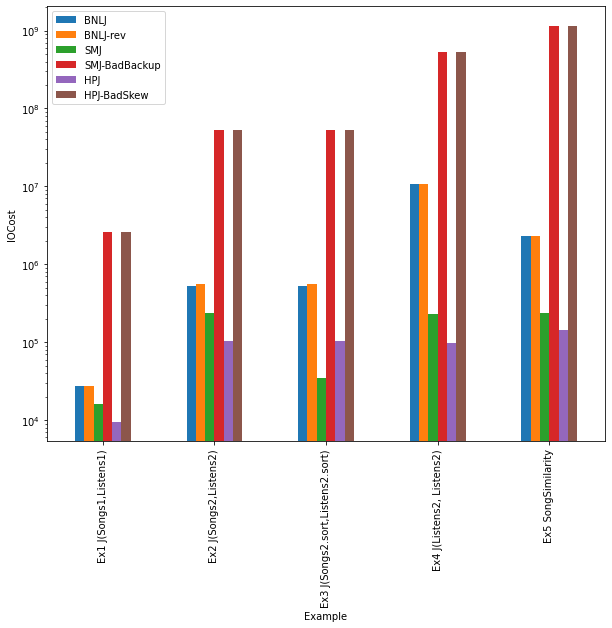

In [ ]:
from IPython.display import display, HTML
import pandas as pd

def addToPd(desc, plans):
  return([desc, plans.get("BNLJ"), plans.get("BNLJ-rev"), 
          plans.get("SMJ"), plans.get("SMJ-BadBackup"), 
          plans.get("HPJ"), plans.get("HPJ-BadSkew"),
          plans.get("GroupBy-Sort"), plans.get("GroupBy-Hash"),
          plans.get("OUT"), plans.get("OUT-uniq")])

# Two example DB configurations
db100 = DBOptimizer(100.0, 1.0, 1.0)
db1000 = DBOptimizer(1000.0, 1.0, 1.0)

ex = []
# Example1: Evaluate JOINing two non-big tables
Songs1 = Table(100.0*GB, 1024.0*Bytes)
Listens1 = Table(100.0*GB, 1024.0*Bytes)
ex.append(addToPd("Ex1 J(Songs1,Listens1)", 
                  db100.EvaluateJoinPlans(Songs1, Listens1)))

# Example2: Evaluate JOINing two big tables
Songs2 = Table(100.0*GB, 1024.0*Bytes)
Listens2 = Table(2.0*TB, 1024.0*Bytes)
ex.append(addToPd("Ex2 J(Songs2,Listens2)", 
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

#Example3: Assume Songs2 and Listens2 are sorted. 
Songs2.Sort()
Listens2.Sort()
ex.append(addToPd("Ex3 J(Songs2.sort,Listens2.sort)", 
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

#Example4: Self-join
Songs2.Reset()
Listens2.Reset()
ex.append(addToPd("Ex4 J(Listens2, Listens2)", 
                  db100.EvaluateJoinPlans(Listens2, Listens2)))

# Example5: from Spotify song_similarity CTE
listens_rowSize = 32.0*Bytes 
listens_numRows = pow(10.0, 11) # 100 billion listens
listens_sizeinMBs = listens_rowSize*listens_numRows/MB # ~= 300 GBs
Listens = Table(listens_sizeinMBs, 32.0*Bytes)
ex.append(addToPd("Ex5 SongSimilarity", 
                  db1000.EvaluateJoinPlans(Listens, Listens)))

pdf = pd.DataFrame(ex, columns= ["Example", "BNLJ", "BNLJ-rev", "SMJ", 
                                 "SMJ-BadBackup", "HPJ", "HPJ-BadSkew",
                                 "GroupBy-Sort", "GroupBy-Hash",
                                 "OUT", "OUT-uniq"])
#grid.append(pdf)

import matplotlib.pyplot as plt
%matplotlib inline
pdf.plot.bar(x='Example', y = ['BNLJ', 'BNLJ-rev', 'SMJ', 'SMJ-BadBackup', 
                               'HPJ', 'HPJ-BadSkew',
                               'GroupBy-Sort', 'GroupBy-Hash', 'OUT', 'OUT-uniq' ],
                               figsize=(10,8), logy=True)
plt.ylabel("IOCost")
plt.show()

In [ ]:
listens_rowSize = 32.0*Bytes 
listens_numRows = pow(10.0, 11) # 10 billion listens
listens_sizeinTBs = listens_rowSize*listens_numRows/TB
print(listens_sizeinTBs)

OBSERVATIONS

Notice in Case 2, BNLJ(R, S) is cheaper than SMJ(R, S). Why? R and S are pretty small vs B.(100 GBs vs 64 GBs of RAM). Intuitively, makes sense. That is, if the data fits in RAM, effectively BNLJ will just process in RAM. And will not have the pre-processing (Sort or HP) overhead.
In other cases, SMJ and HPJ do better than BNLJ. Especially, when P_R and P_S is big compared to B. SMJ and HPJ do even better, if they were pre-sorted or pre-partitioned (perhaps for another query or index).